### 🎯 What You'll Learn
By the end of this tutorial, you will:

    ✅ Understand LangGraph's core concepts (Nodes, Edges, State)
    ✅ Build your first simple chatbot
    ✅ Add memory and persistence to conversations
    ✅ Implement tool calling and external integrations
    ✅ Create human-in-the-loop workflows
    ✅ Build multi-agent systems
    ✅ Handle complex state management
    ✅ Deploy production-ready applications

### 📚 Based on Official LangGraph Documentation
This tutorial follows the official LangGraph documentation and incorporates best practices from the LangGraph team.
1. https://langchain-ai.github.io/langgraph/concepts/why-langgraph/
2. https://langchain-ai.github.io/langgraph/?

### 🚀 Complete LangGraph Tutorial: From Basics to Advanced Applications
📖 Comprehensive Guide for Building Stateful AI Agents
Welcome to the most comprehensive LangGraph tutorial! This notebook will take you from complete beginner to building sophisticated AI agents step by step.

🎯 What You'll Learn
By the end of this tutorial, you will:

    ✅ Understand LangGraph's core concepts (Nodes, Edges, State)
    ✅ Build your first simple chatbot
    ✅ Add memory and persistence to conversations
    ✅ Implement tool calling and external integrations
    ✅ Create human-in-the-loop workflows
    ✅ Build multi-agent systems
    ✅ Handle complex state management
    ✅ Deploy production-ready applications
    📚 Based on Official LangGraph Documentation
This tutorial follows the official LangGraph documentation and incorporates best practices from the LangGraph team.

    📋 Table of Contents
    Setup & Installation
    Part 1: Understanding LangGraph Fundamentals
    Part 2: Building Your First Simple Agent
    Part 3: Adding Memory with Checkpointing
    Part 4: Tool Integration & External APIs
    Part 5: Human-in-the-Loop Workflows
    Part 6: Advanced State Management
    Part 7: Multi-Agent Systems
    Part 8: Real-World Use Cases
    Part 9: Production Deployment

### Let's begin this exciting journey! 🌟

🔧 Setup & Installation {#setup}
Before we dive into LangGraph, let's set up our environment properly.

Prerequisites
    Python 3.8+ installed on your system
    API Keys for LLM providers (we'll use OpenAI in this tutorial)
    Basic Python knowledge - understanding of functions, classes, and dictionaries
    What is LangGraph?
    LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to coordinate multiple chains (or actors) across multiple steps of computation in a cyclic manner.

Key features:

    🔄 Flexible workflows (neither just linear chains not cyclic workflows or a cycle of steps)
    💾 Persistent state across interactions
    🎯 Conditional routing between different paths
    🔧 Human-in-the-loop capabilities
    📊 Built-in observability with LangSmith
    Think of it as a way to build AI agents that can:

    Remember previous conversations
    Make decisions about what to do next
    Use tools and external APIs
    Involve humans when needed
    Handle complex, multi-step workflows

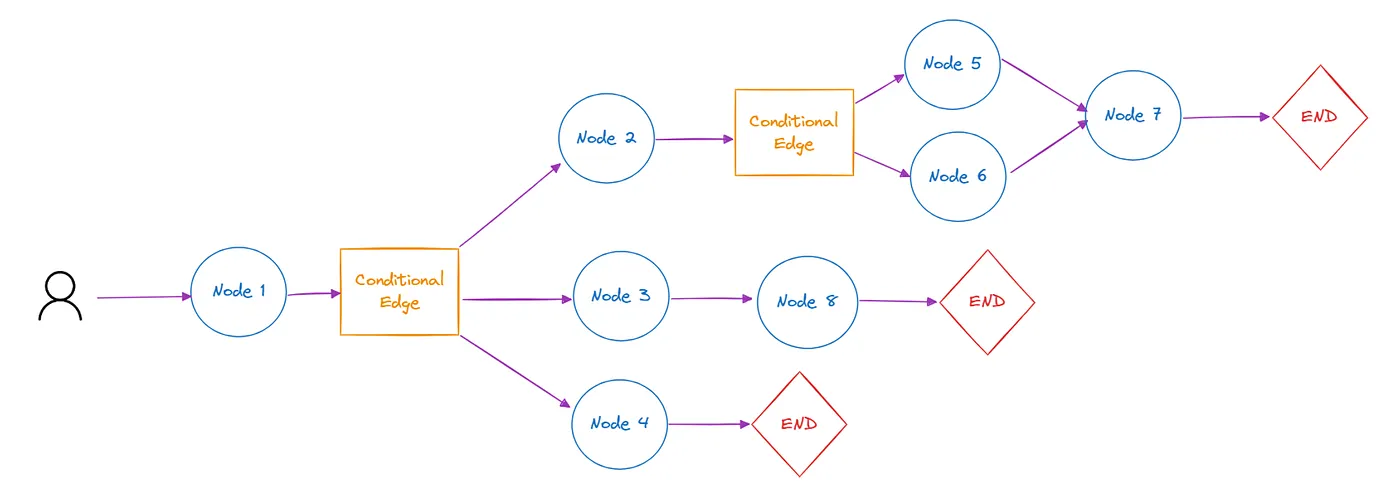

### 🧠 Part 1: Understanding LangGraph Fundamentals {#part1}
Before we build anything, let's understand the core concepts that make LangGraph powerful.

🔑 Core Concepts
1. State
The "memory" of your application
Shared data structure that persists across all steps
Can contain messages, variables, flags, or any data you need
2. Nodes
Individual functions or operations in your workflow
Each node receives the current state and returns updates
Think of them as "workers" that do specific tasks
3. Edges
Connections between nodes that define the flow
Can be simple (A → B) or conditional (A → B or C based on logic)
4. Graph
The complete workflow combining nodes and edges
Defines how your AI agent behaves and makes decisions
🎯 Simple Mental Model
Think of LangGraph like a flowchart for AI agents:

[User Input] → [AI Thinks] → [Uses Tool?] 
                    ↓              ↓
               [Respond]      [Call Tool] → [AI Thinks] → [Respond]
But unlike a simple flowchart, LangGraph can:

Remember everything that happened before
Loop back to previous steps
Involve humans in the decision-making
Handle complex, branching logic
Let's see this in action! 👇

### 🤖 Part 2: Building Your First Simple Agent {#part2}
Let's start with the simplest possible LangGraph application - a basic chatbot that can have a conversation.

In [2]:
# Install required packages
%pip install -q langgraph langsmith python-dotenv langchain_community langchain_huggingface langchain_groq

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# t = {'key': "values"}
# type(t)

# t = [1,2,'amit', 4.5, True]
# type(t)

list

In [47]:
from typing import Annotated, Dict, List, Any
from typing_extensions import Annotated,List, TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
# from langchain_huggingface import HuggingFaceEmbeddings

# from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"




True

In [13]:
from dotenv import load_dotenv
load_dotenv()

True

Basic Chatbot

In [8]:
# llm = ChatGoogleGenerativeAI(model = "gemini-1.0-pro")
llm = ChatGroq(model="openai/gpt-oss-20b")
llm.invoke("Hello, how are you?")



AIMessage(content='Hello! I’m just a bunch of code, but I’m running smoothly—thanks for asking. How can I help you today?', additional_kwargs={'reasoning_content': 'User: "Hello, how are you?" They want a friendly response. We should respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 77, 'total_tokens': 134, 'completion_time': 0.051364724, 'prompt_time': 0.005084865, 'queue_time': 0.052271295, 'total_time': 0.056449589}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_59f77feedf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--24eaeb11-e1c7-4129-b381-a2faf1881511-0', usage_metadata={'input_tokens': 77, 'output_tokens': 57, 'total_tokens': 134})

### Step 1: Define the State
The state is like the "memory" of our agent. For a chatbot, we need to remember the conversation history.

In [15]:

# Define our State - this is the "memory" of our agent
class State(TypedDict):
    # messages will store our conversation history
    # add_messages is a special function that appends new messages instead of replacing them
    messages: Annotated[list, add_messages]

print("✅ State defined!")
print("Our state has one field: 'messages' that will store the conversation history")
print("The add_messages function ensures new messages are appended, not replaced")

✅ State defined!
Our state has one field: 'messages' that will store the conversation history
The add_messages function ensures new messages are appended, not replaced


In [16]:
def chatbot_node(state: State) -> Dict[str, Any]:
    """
    The main chatbot node that processes messages and generates responses.
    
    Args:
        state: Current state containing conversation history
        
    Returns:
        Dict with new messages to add to state
    """
    # Get the conversation history from state
    messages = state["messages"]
    
    # Call the LLM with the conversation history
    response = llm.invoke(messages)
    
    # Return the new message to be added to state
    return {"messages": [response]}

print("✅ Chatbot node created!")
print("This node will:")
print("1. Take the conversation history from state")
print("2. Send it to the LLM")
print("3. Return the LLM's response to be added to state")

✅ Chatbot node created!
This node will:
1. Take the conversation history from state
2. Send it to the LLM
3. Return the LLM's response to be added to state


In [17]:
# Step 1: Create the graph builder
graph_builder = StateGraph(State)

# Step 2: Add our chatbot node
graph_builder.add_node("chatbot", chatbot_node)

# Step 3: Define the flow
# START -> chatbot -> END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Step 4: Compile the graph
simple_chatbot = graph_builder.compile()

print("✅ Simple chatbot graph created!")
print("Flow: START → chatbot → END")
print("Ready to chat! 🎉")

✅ Simple chatbot graph created!
Flow: START → chatbot → END
Ready to chat! 🎉


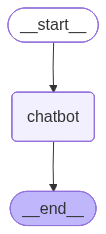

In [18]:
from IPython.display import Image, display

try:
    display(Image(simple_chatbot.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass




In [19]:
simple_chatbot.invoke({"messages":"what is the capital of India?"})


{'messages': [HumanMessage(content='what is the capital of India?', additional_kwargs={}, response_metadata={}, id='f0c710c9-4622-43cd-b191-f9936a23145d'),
  AIMessage(content='The capital of India is **New\u202fDelhi**.', additional_kwargs={'reasoning_content': 'User asks: "what is the capital of India?" Straight answer: New Delhi. Provide concise.'}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 78, 'total_tokens': 119, 'completion_time': 0.036380278, 'prompt_time': 0.00503633, 'queue_time': 0.0473536, 'total_time': 0.041416608}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_a5ac2a5d7b', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--b0fb6916-5394-4860-b8f3-f6daa290c359-0', usage_metadata={'input_tokens': 78, 'output_tokens': 41, 'total_tokens': 119})]}

In [20]:
def stream_graph(user_inpit:str):
    for event in simple_chatbot.stream({"messages":[{"role":"user","content":user_inpit}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
    


In [25]:
stream_graph("who won the yestarday cricket match b/w sri lanka and India")

Assistant: I’m sorry, but I don’t have that information.


In [73]:
# while True:
#     try:
#         user_input = input()
#         if user_input.lower in ['quit','bye']:
#             print("GoodBye")
#             break
#         stream_graph(user_input)
#     except:
#         user_input = 'how do I learn Python'
#         stream_graph(user_input)
#         break

In [22]:
search = TavilySearchResults(max_results=2)
search.invoke('what is the recent new about us visa and trump')

/var/folders/y3/l1qzr2852s51qbvnph6b1qf80000gp/T/ipykernel_31163/1349080116.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=2)


[{'title': 'Trump Administration Proposes New Rule To End Foreign Student ...',
  'url': 'https://www.dhs.gov/news/2025/08/27/trump-administration-proposes-new-rule-end-foreign-student-visa-abuse',
  'content': '### News\n\n### In Focus\n\n### How Do I?\n\n### Get Involved\n\n### About DHS\n\n# Trump Administration Proposes New Rule to End Foreign Student Visa Abuse\n\nNew rule will limit the amount of time that foreign students, professors, physicians, and other visa holders are allowed to remain in the United States without additional screening and vetting [...] WASHINGTON, DC – Wednesday, the Trump Administration announced a proposed rule that, if finalized, would limit the length of time certain visa holders – including foreign students– are allowed to stay in the United States, thereby curbing visa abuse and increasing the Department of Homeland Security’s ability to properly vet and oversee these individuals. [...] “For too long, past Administrations have allowed foreign students

Chatbot with tool

In [36]:
# llm = ChatGoogleGenerativeAI(model = "gemini-1.0-pro")
# llm = ChatGroq(model = "gemma2-9b-it")
search = TavilySearchResults(max_results=2)

tools = [search]
llm_with_bind_tools = llm.bind_tools(tools)



class State(TypedDict):
    messages: Annotated[List,add_messages]

def chat_model(state):
    return {"messages": [llm_with_bind_tools.invoke(state['messages'])]}



workflow_graph = StateGraph(State)
workflow_graph.add_node("chatbot", chat_model)
tools = ToolNode(tools)
workflow_graph.add_node("tools",tools)
workflow_graph.add_edge(START,"chatbot")
workflow_graph.add_conditional_edges("chatbot",tools_condition)
workflow_graph.add_edge("tools","chatbot")
# workflow_graph.add_edge("chatbot",END)

graph = workflow_graph.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [37]:
def stream_graph(user_inpit:str):
    for event in graph.stream({"messages":[{"role":"user","content":user_inpit}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [38]:
user_input = "who is prime minister of India"
events = graph.stream({"messages":[{"role":"user","content":user_input}]},
                      stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

who is prime minister of India
================================== Ai Message ==================================

The Prime Minister of India is **Narendra Modi**. He has been in office since May 26, 2014, serving as the head of the Indian government and leading the Bharatiya Janata Party (BJP).


In [39]:
user_input = "what is his age?"
events = graph.stream({"messages":[{"role":"user","content":user_input}]},
                      stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is his age?
================================== Ai Message ==================================

I’m not sure who you’re referring to. Could you let me know which person you’re asking about?


Chatbot with tool and memory

In [40]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [50]:
@tool
def presoanl_info():
    """whenever something been asked about arun, use this tool"""
    arun_info = {}
    name = "Arun"
    age = 40
    gender = "M"
    arun_info['name'] = name
    arun_info['age'] = age
    arun_info['gender'] = gender
    return arun_info






In [53]:
arun_tool = presoanl_info.invoke('age')

In [46]:
presoanl_info()

{'name': 'Arun', 'age': 40, 'gender': 'M'}

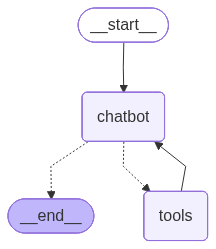

In [55]:
# llm = ChatGoogleGenerativeAI(model = "gemini-1.0-pro")
# llm = ChatGroq(model = "gemma2-9b-it")
search = TavilySearchResults(max_results=2)
tools = [search]
llm_with_bind_tools = llm.bind_tools(tools)



class State(TypedDict):
    messages: Annotated[List,add_messages]

def chat_model(state):
    return {"messages": [llm_with_bind_tools.invoke(state['messages'])]}


workflow_graph = StateGraph(State)
workflow_graph.add_node("chatbot", chat_model)
tools = ToolNode(tools)
workflow_graph.add_node("tools",tools)
workflow_graph.add_edge(START,"chatbot")
workflow_graph.add_conditional_edges("chatbot",tools_condition)
workflow_graph.add_edge("tools","chatbot")
# workflow_graph.add_edge("chatbot",END)

graph = workflow_graph.compile(checkpointer = memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [42]:
config = {"configurable": {"thread_id": "ndfsnSnsdn"}}

In [43]:
user_input = "who is prime minister of india?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

who is prime minister of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_18575887-1f44-4b32-96d0-fed37d94aabd)
 Call ID: fc_18575887-1f44-4b32-96d0-fed37d94aabd
  Args:
    query: current prime minister of India 2025
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Telephone conversation with Prime Minister of India Narendra Modi", "url": "http://en.kremlin.ru/events/president/news/78013", "content": "The two\nleaders discussed the preparations for the Russian President's upcoming visit\nto India, which is planned for December this year, and addressed a range of international issues, including the situation surrounding Ukraine.\n\nIn addition, the President of Russia sent Narendra Modi a message of greetings.\n\n### See also\n\n### Geography\n\n

In [44]:
user_input = "what is his age?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is his age?
================================== Ai Message ==================================

Narendra Modi was born on **17 September 1950**. As of today (21 September 2025) he is **75 years old**.


In [ ]:
user_input = "I am staying in Bangalore, BTM 2nd stage. Every Saturday I used to Play cricket and read some stateof the art paper in AI"


# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I am staying in Bangalore, BTM 2nd stage. Every Saturday I used to Play cricket and read some stateof the art paper in AI
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_rw83)
 Call ID: call_rw83
  Args:
    query: What are some state-of-the-art papers in AI?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.sciencedirect.com/science/article/pii/S2452414X21000248", "content": "Since 1993, AI has achieved some milestone results. Due to the wide application of the BP algorithm, the neural network has developed rapidly. ... applicable scenarios, and challenges. This paper conducts a state-of-the-art review of the extant and upcoming research on AI. Artificial intelligence is an interdisciplinary subject that involves"}, {"url": "https://www.sci

In [ ]:
user_input = "do you remember my name?"


# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

do you remember my name?
================================== Ai Message ==================================

Yes, your name is Amit.


In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Amit', additional_kwargs={}, response_metadata={}, id='65c1ec77-4960-4b3d-a701-7020aab50c56'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vcpm', 'function': {'arguments': '{"query":"What is your name?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 988, 'total_tokens': 1077, 'completion_time': 0.161818182, 'prompt_time': 0.040582389, 'queue_time': 0.05072071699999999, 'total_time': 0.202400571}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bb474c85-9649-4af0-8a3c-65e9911a0ad5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'What is your name?'}, 'id': 'call_vcpm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 988, 'output_tokens': 89, 'total_tokens': 1077}), ToolMessage(conten

Chatbot with Human in the loop

In [92]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

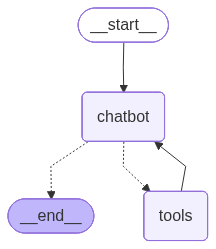

In [94]:
class State(TypedDict):
    messages:Annotated[List, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


search = TavilySearchResults(max_results=2)
llm = ChatGroq(model = "gemma2-9b-it")
tools = [search,human_assistance]
llm_with_bind_tools = llm.bind_tools(tools)

def chat_model(state):
    message= llm_with_bind_tools.invoke(state['messages'])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chat_model)
tools = ToolNode(tools)
graph_builder.add_node("tools",tools)
graph_builder.add_edge(START,"chatbot")
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools","chatbot")
# workflow_graph.add_edge("chatbot",END)

# graph = graph_builder.compile(interrupt_before=["tools"],checkpointer = memory)
graph = graph_builder.compile(checkpointer = memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass




In [66]:
# Human in the loop


from typing import Annotated
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = input({"query": query})
    return human_response["data"]

@tool
def presoanl_info(query=None):
    """whenever something been asked about arun, use this tool"""
    arun_info = {}
    name = "Arun"
    age = 40
    gender = "M"
    arun_info['name'] = name
    arun_info['age'] = age
    arun_info['gender'] = gender
    return arun_info


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance,presoanl_info]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [67]:
memory = InMemorySaver()

graph = graph_builder.compile(checkpointer=memory)

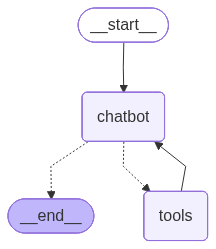

In [68]:

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [69]:
user_input = "Can you compare the age between Amit and Modi"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you compare the age between Amit and Modi
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_abab08d0-99c1-418d-8735-2aeb1ea475ac)
 Call ID: fc_abab08d0-99c1-418d-8735-2aeb1ea475ac
  Args:
    query: Amit Shah birth date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Amit Shah | Indian Politician, BJP Leader, Career, Family, & Facts", "url": "https://www.britannica.com/biography/Amit-Shah", "content": "Amit Shah (born October 22, 1964, Bombay (now Mumbai), Maharashtra, India) is an Indian politician and one of the most prominent leaders of the Bharatiya Janata Party (BJP). He has served as the central government minister for home affairs since 2019 and the minister of cooperation since 2021. Shah, the BJP’s top strategist, is considered the architec

In [65]:

human_response = (
    "Amit Shah"
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Sure! To give you an accurate comparison, could you let me know which “Amit” you’re referring to? For example:

- Amitabh Bachchan (actor)  
- Amit Shah (politician)  
- Amitabh Singh (any other public figure)  

Once I know which Amit you mean, I can tell you both their current ages and how they compare.


In [67]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_rwxe)
 Call ID: call_rwxe
  Args:
    query: I need some expert guidance for building an AI agent. Could you please connect me with someone who specializes in this area?


In [69]:
snapshot = graph.get_state(config=config)

In [70]:
snapshot.next

('tools',)

In [71]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_rwxe)
 Call ID: call_rwxe
  Args:
    query: I need some expert guidance for building an AI agent. Could you please connect me with someone who specializes in this area?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Thank you for that information! It sounds like LangGraph could be a great resource for building your AI agent.  Would you like me to find some more information about LangGraph for you?


Customization

In [97]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [58]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [59]:

from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGroq(model = "gemma2-9b-it")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

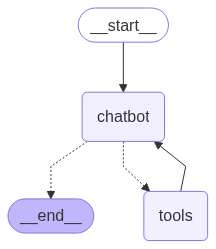

In [60]:
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [61]:
user_input = (
    "Can you look up when LangGraph was released? "
     "When you have the answer, use the human_assistance tool for review."
   
)
config = {"configurable": {"thread_id": "3"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (q2jpd9s10)
 Call ID: q2jpd9s10
  Args:
    query: When was LangGraph released?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangChain Introduces LangGraph Studio: The First Agent IDE for ...", "url": "https://www.marktechpost.com/2024/08/03/langchain-introduces-langgraph-studio-the-first-agent-ide-for-visualizing-interacting-with-and-debugging-complex-agentic-applications/", "content": "LangGraph, launched in January 2023, is a highly controllable, low-level orchestration framework for building agentic applications. Since its inception, it has undergone significant improvements, leading to a s

In [62]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (qxvtv3bdk)
 Call ID: qxvtv3bdk
  Args:
    birthday: N/A
    name: Bard Assistant
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released on Jan 17, 2024.


In [ ]:
#when to use command and when to use conditional edge?